# Preamble

This notebook demonstrates ways to run CosmoSIS from a jupyter notebook or other python code.

The downside to jupyter is that it's not easy to run CosmoSIS in parallel, which is much faster for large jobs.  But it can be useful for exploring.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np

import cosmosis
import cosmosis.postprocessing

This example is designed to be run from the main CosmoSIS Standard Library directory, so we first switch to there.

In [2]:
dirname = os.getcwd()
if os.getcwd().endswith("cosmosis-standard-library" + os.path.sep + "examples"):
    print("Switching to directory above to run examples")
    os.chdir(os.path.pardir)

Switching to directory above to run examples


---

# Basic usage

The usual way to run CosmoSIS is by writing several parameter files.  Let's run an example analysis: an example of fitting Supernova data using the "emcee" sampling method.

## Running Cosmosis

(If you get a message starting "You told me to resume the chain ..." then don't worry, it just means you've already run this example so the results already exist).

This is equivalent to running on the command line: `cosmosis examples/pantheon.ini`.

In [3]:
cosmosis.run_cosmosis("examples/pantheon.ini")

Setting up pipeline from parameter file examples/pantheon.ini
-------------------------------------------------------------

Setting up module consistency
------------------------------

Setting up module astropy
--------------------------

Setting up module pantheon
---------------------------
Loading Pantheon data from /Users/jzuntz/src/cosmosis/cosmosis-standard-library/likelihood/pantheon/lcparam_DS17f.txt
Found 40 Pantheon supernovae (or bins if you used the binned data file)
Loading Pantheon covariance from /Users/jzuntz/src/cosmosis/cosmosis-standard-library/likelihood/pantheon/sys_DS17f.txt

Setting up module riess21
--------------------------
Likelihood "riess21" will be Gaussian 0.732 +/- 0.013 
Setup all pipeline modules


Parameter Priors
----------------
cosmological_parameters--omega_m  ~ U(0.15, 0.4)
cosmological_parameters--h0       ~ U(0.6, 0.8)
cosmological_parameters--w        ~ delta(-1.0)
cosmological_parameters--omega_b  ~ delta(0.04)
cosmological_parameters--omeg

0

The printed output above shows us several things:

- Information from the setup phase of the modules (see below).

- Priors on our parameters, uniform (U) and fixed (delta).

- Details about the sampler and where its output will go.

- The progress of the sampling.

## Getting chain output interactively in a notebook or script

By default CosmoSIS saves output to a file, but you can get the output directly in python by setting the output parameter. The simplest choice for it is `astropy`, which will give you an astropy table of the results.

Note that in this form the chain can't resume from an existing run, so for larger or slower runs it's wiser to save to file.

In [4]:
status, chain = cosmosis.run_cosmosis("examples/pantheon.ini", output="astropy")

Setting up pipeline from parameter file examples/pantheon.ini
-------------------------------------------------------------

Setting up module consistency
------------------------------

Setting up module astropy
--------------------------

Setting up module pantheon
---------------------------
Loading Pantheon data from /Users/jzuntz/src/cosmosis/cosmosis-standard-library/likelihood/pantheon/lcparam_DS17f.txt
Found 40 Pantheon supernovae (or bins if you used the binned data file)
Loading Pantheon covariance from /Users/jzuntz/src/cosmosis/cosmosis-standard-library/likelihood/pantheon/sys_DS17f.txt

Setting up module riess21
--------------------------
Likelihood "riess21" will be Gaussian 0.732 +/- 0.013 
Setup all pipeline modules


Parameter Priors
----------------
cosmological_parameters--omega_m  ~ U(0.15, 0.4)
cosmological_parameters--h0       ~ U(0.6, 0.8)
cosmological_parameters--w        ~ delta(-1.0)
cosmological_parameters--omega_b  ~ delta(0.04)
cosmological_parameters--omeg

Our table contains the cosmological parameters that were varied during the chain. The one in capital letters is a derived parameter calculated from the others.

Let's look at the start of the table:

In [5]:
chain[:10]

cosmological_parameters--omega_m,cosmological_parameters--h0,cosmological_parameters--omega_k,supernova_params--m,COSMOLOGICAL_PARAMETERS--OMMH2,prior,post
float64,float64,float64,float64,float64,float64,float64
0.2992938714584453,0.7000027603370182,-0.0007619545822361763,-19.348010616256353,0.14665515362965248,2.407945608651871,-21.494930026411083
0.30026178173627766,0.7001285087656367,-0.00012495197405987198,-19.348002399980302,0.14718229878876443,2.407945608651871,-21.423790415786367
0.2996033599006513,0.7000345219695008,0.0001527753271882929,-19.35182179593315,0.1468201267656503,2.407945608651871,-21.63541952963154
0.2998673312688457,0.7001746716070976,0.001670717014892853,-19.34898782089971,0.14700833110287403,2.407945608651871,-21.428318241616527
0.2995404373654804,0.6998860203633641,-0.0027022881284254406,-19.350852584754854,0.1467270200862302,2.407945608651871,-21.456374434283326
0.2997759378415569,0.7001355815781959,0.0015927014030337806,-19.34970420973681,0.1469471167856142,2.407945608651871,-21.46561144969221
0.30056321574172534,0.6996860759306444,0.00047535037646815237,-19.352616121976983,0.14714390969454783,2.407945608651871,-21.744395707618335
0.30023805867758235,0.7000369011536977,4.1911137030413735e-05,-19.348535830253365,0.14713215994389686,2.407945608651871,-21.434988949023793
0.30029166193410883,0.7003251303451211,0.001134344508618633,-19.34659723245655,0.14727963359582152,2.407945608651871,-21.417367182362923


## Plots of interactive output

We can now make plots of this output.  For example, let's look at the trace of a single parameter in the chain.  Emcee chains usually require you to remove a non-representative "burn-in" period at the start of the chain where the sampler is moving towards its steady state. Let's have a look at that.

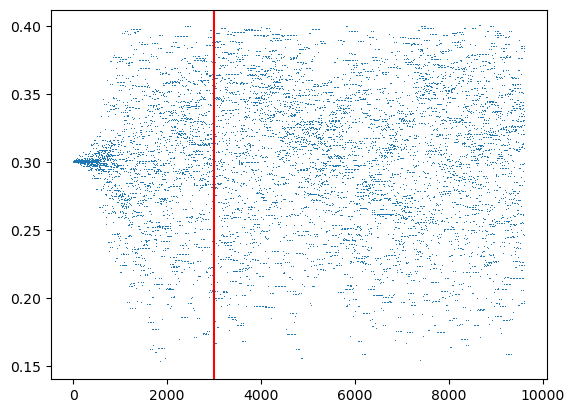

In [6]:
plt.plot(chain["cosmological_parameters--omega_m"], ',')

# The plot will show the chain is not burnt in until about 3000 samples
burn = 3000
plt.axvline(burn, color='r')

It looks like the chain is settled after about 3000 samples. So let's make a histogram of the $\Omega_m$ parameter from that point in the chain onwards; it should be a reasonable estimate of the posterior.

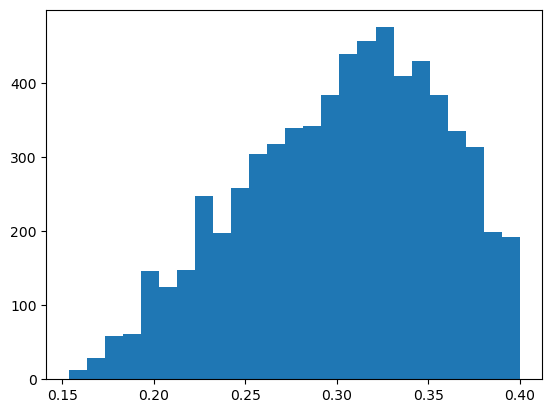

In [7]:
# Cut out the start
chain1 = chain[burn:]

# Make a plot
plt.figure()
plt.hist(chain1['cosmological_parameters--omega_m'], bins=25);

---


# Customizing runs

We can modify the choices made in the analysis by changing the parameters or values

The parameters configure the *pipeline*, *modules*, and the *sampler*.  Here they read directly from `examples/pantheon.ini`

The values defines the numerical parameters that might be varied in the sampling process. The name of the values file is set in the parameter file, in the `values` option in the `pipeline` section.

Instead of having CosmoSIS read these from the file for us, we can also read them ourselves and modify them

## Cosmosis configuration files

A CosmoSIS run is defined by two required configuration files and one optional one. Each is in the ini file format, which has sections that define categories of parameters and then key/value pairs within each section.

The **parameter file** (required) defines the sequence of calculations (modules) used int the analysis, the sampler settings, and configuration for each individual module.

The **values file** (required) lists the numerical inputs that the sampler can vary. It defines the range of values they can take, and a starting point value.

The **priors file** (optional) lists extra priors to apply to parameters.

You tell CosmoSIS the parameter file. The parameter file contains the paths to the other two files.  In our Pantheon case the parameter file is `examples/pantheon.ini` and the values file is `examples/pantheon_values.ini`.  There is no priors file used here.

In [8]:
# Let's look at the start of our values file here.

!head -6 examples/pantheon_values.ini

[cosmological_parameters]
omega_m  =  0.15    0.3    0.4
h0  =  0.6  0.7  0.8
w  =  -1.0
omega_b  =  0.04
omega_k  =  -0.3  0.0  0.3


Here the section is called `cosmological_parameters` and there are various parameters in that category listed.

## Exploring & modifying pipeline choices

Instead of giving CosmoSIS the path to the ini file, we can load it ourselves:

In [9]:
ini = cosmosis.Inifile("examples/pantheon.ini")

Then we can explore its contents here:

In [10]:
print("Sections in the file:")
for section in ini.sections():
    print("    ", section)

print()

print("Options in the [camb] section, for example:")
for key, value in ini.items('camb'):
    print("    ", key, "=", value)

Sections in the file:
     runtime
     emcee
     polychord
     multinest
     output
     pipeline
     maxlike
     metropolis
     test
     astropy
     camb
     pantheon
     riess21
     consistency

Options in the [camb] section, for example:
     file = boltzmann/camb/camb_interface.py
     mode = background
     feedback = 0
     nz_background = 200
     zmin_background = 0.0
     zmax_background = 2.0


We can modify the content of the parameter file

Let's change to use a different sampler, called nautilus. You can override any of the values in the file easily enough, or add new ones:

In [11]:
ini['runtime', 'sampler'] = 'nautilus'
ini['runtime', 'resume'] = 'False'
ini['runtime', 'verbosity'] = 'quiet'

In [12]:
status, chain2 = cosmosis.run_cosmosis(ini, output='astropy')

Setting up pipeline from pre-constructed configuration
------------------------------------------------------

Setting up module consistency
------------------------------

Setting up module astropy
--------------------------

Setting up module pantheon
---------------------------
Loading Pantheon data from /Users/jzuntz/src/cosmosis/cosmosis-standard-library/likelihood/pantheon/lcparam_DS17f.txt
Found 40 Pantheon supernovae (or bins if you used the binned data file)
Loading Pantheon covariance from /Users/jzuntz/src/cosmosis/cosmosis-standard-library/likelihood/pantheon/sys_DS17f.txt

Setting up module riess21
--------------------------
Likelihood "riess21" will be Gaussian 0.732 +/- 0.013 
Setup all pipeline modules


Parameter Priors
----------------
cosmological_parameters--omega_m  ~ U(0.15, 0.4)
cosmological_parameters--h0       ~ U(0.6, 0.8)
cosmological_parameters--w        ~ delta(-1.0)
cosmological_parameters--omega_b  ~ delta(0.04)
cosmological_parameters--omega_k  ~ U(-0.3,

The nautilus sampler takes a little longer but generates a very clean posterior sample. Note that there is a new `log_weight` column for this sample - we need to use this weight when making constraints.

In [13]:
chain2.info()

<Table length=43400>
              name                dtype 
-------------------------------- -------
cosmological_parameters--omega_m float64
     cosmological_parameters--h0 float64
cosmological_parameters--omega_k float64
             supernova_params--m float64
  COSMOLOGICAL_PARAMETERS--OMMH2 float64
                      log_weight float64
                           prior float64
                            post float64


Let's compare to our emcee histogram using the new samples. Nautilus doesn't have a burn-in period in the output.

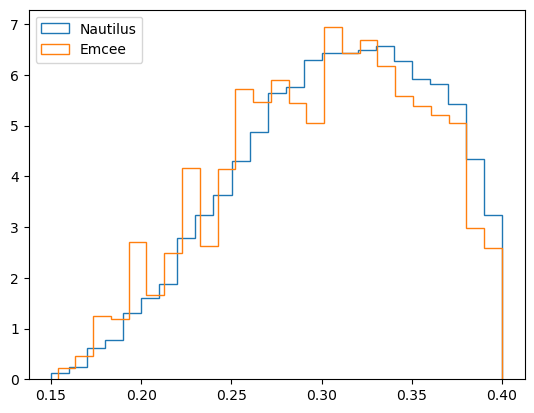

In [14]:
plt.hist(
    chain2['cosmological_parameters--omega_m'],
    weights=np.exp(chain2['log_weight']),
    bins=25,
    histtype='step',
    density=1,
    label='Nautilus'
);

plt.hist(
    chain1['cosmological_parameters--omega_m'][burn:],
    bins=25,
    histtype='step',
    density=1,
    label='Emcee'
);
plt.legend()

## Modifying numerical parameter values

As well as modifying the chain, we can change the sampled parameters.  For instance, in the current chain the value of the dark energy equation of state, $w$, is fixed to the cosmological constant value of -1:

In [15]:
values = cosmosis.Inifile("examples/pantheon_values.ini")
values['cosmological_parameters', 'w']

'-1.0'

Let's free that parameter and run a new chain.  We can do this by passing the `values` directly to `run_cosmosis`, instead of reading from the file. In this case that will involve changing both the parameter file, to tell the astropy distance calculation what to expect:

In [16]:
ini2 = cosmosis.Inifile(ini)
ini2['astropy', 'model'] = 'wcdm'

... and also modifying the values file to free the parameter:

In [17]:
values['cosmological_parameters', 'w'] = "-3.0  -1.0  -0.5"
status, chain3 = cosmosis.run_cosmosis(ini2, values=values, output="astropy")

Setting up pipeline from pre-constructed configuration
------------------------------------------------------

Setting up module consistency
------------------------------

Setting up module astropy
--------------------------

Setting up module pantheon
---------------------------
Loading Pantheon data from /Users/jzuntz/src/cosmosis/cosmosis-standard-library/likelihood/pantheon/lcparam_DS17f.txt
Found 40 Pantheon supernovae (or bins if you used the binned data file)
Loading Pantheon covariance from /Users/jzuntz/src/cosmosis/cosmosis-standard-library/likelihood/pantheon/sys_DS17f.txt

Setting up module riess21
--------------------------
Likelihood "riess21" will be Gaussian 0.732 +/- 0.013 
Setup all pipeline modules


Parameter Priors
----------------
cosmological_parameters--omega_m  ~ U(0.15, 0.4)
cosmological_parameters--h0       ~ U(0.6, 0.8)
cosmological_parameters--w        ~ U(-3.0, -0.5)
cosmological_parameters--omega_b  ~ delta(0.04)
cosmological_parameters--omega_k  ~ U(-0.

That will take a little longer to run, but afterwards we can look at Pantheon constraints on w:

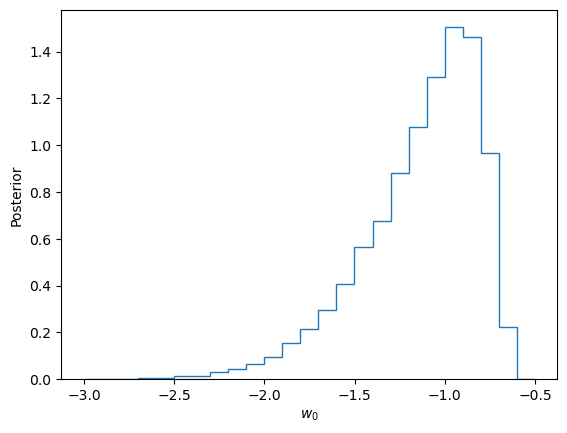

In [18]:
plt.hist(
    chain3['cosmological_parameters--w'],
    weights=np.exp(chain3['log_weight']),
    bins=25,
    density=1,
    histtype='step'
);
plt.xlabel("$w_0$")
plt.ylabel("Posterior");

We can also see how the other parameters like $\Omega_m$ are affected:

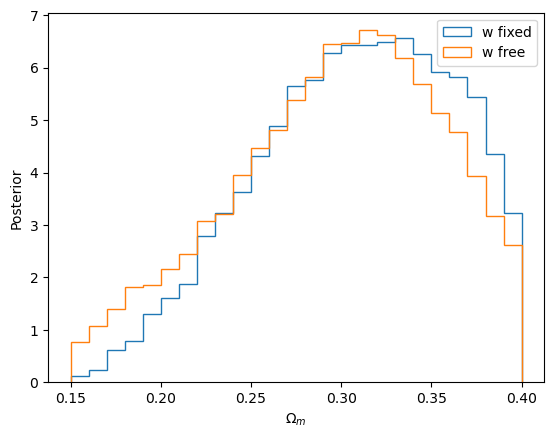

In [19]:
plt.hist(
    chain2['cosmological_parameters--omega_m'],
    weights=np.exp(chain2['log_weight']),
    bins=25,
    histtype='step',
    density=1,
    label='w fixed'
);

plt.hist(
    chain3['cosmological_parameters--omega_m'],
    weights=np.exp(chain3['log_weight']),
    bins=25,
    histtype='step',
    density=1,
    label='w free'
)
plt.legend()
plt.xlabel("$\Omega_m$")
plt.ylabel("Posterior");

We can also make a scatter plot showing how two of our parameters are correlated. To do that we need to make a chain where all the weights are equal:

In [20]:
weight = np.exp(chain3['log_weight'])

# The ESS is the effective sample size, which takes into account that lower weighted parameters
# do not contribute much to the sample.
effective_sample_size = int(weight.sum()**2 / (weight ** 2).sum())
print("ESS = ", effective_sample_size)

ESS =  14865


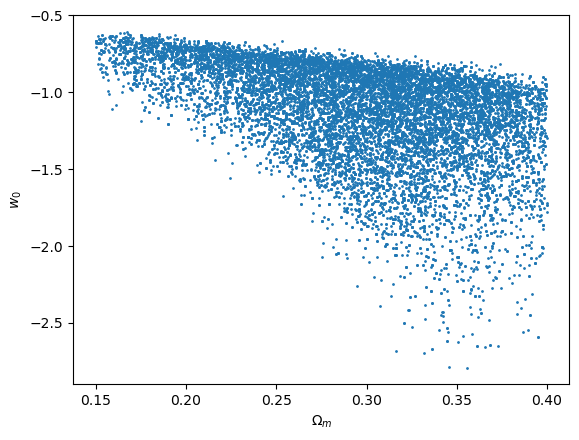

In [21]:
index = np.arange(len(chain3))
random_sample = np.random.choice(index, effective_sample_size, p=weight)
equal_weight_chain = chain3[random_sample]

plt.scatter(
    equal_weight_chain['cosmological_parameters--omega_m'],
    equal_weight_chain['cosmological_parameters--w'],
    s=1,
)

plt.xlabel("$\Omega_m$")
plt.ylabel("$w_0$");

--- 

# Manually running pipelines

## Creating pipelines

As well running CosmoSIS automatically using the `run_cosmosis`, we can create and use a pipeline object. This can be useful for exploring models manually, or for code verification.

Let's make a pipeline of the DES Year-3 Lensing + Clustering likelihood.  We will load this from an example file (we could create this from our own Inifile object like we did above if we preferred).

In [22]:
pipe = cosmosis.LikelihoodPipeline("examples/des-y3.ini")

Reading included ini file: `examples/des-y3-scale-cuts.ini'

Setting up module consistency
------------------------------

Setting up module bbn_consistency
----------------------------------

Setting up module camb
-----------------------

Setting up module fast_pt
--------------------------
You have asked for quantities from FAST-PT. FAST-PT will be run.

Setting up module fits_nz
--------------------------
Loading number density data from likelihood/des-y3/2pt_NG_final_2ptunblind_02_24_21_wnz_covupdate.v2.fits:
    Looking at FITS extension NZ_LENS:
        Found 5 bins
    Looking at FITS extension NZ_SOURCE:
        Found 4 bins
        Putting n(0) = 0 at the start of the n(z)

Setting up module lens_photoz_width
------------------------------------

Setting up module lens_photoz_bias
-----------------------------------

Setting up module source_photoz_bias
-------------------------------------

Setting up module IA
---------------------

Setting up module pk_to_cl_gg
-----------

9 4 3
Including -0.5*|C| normalization in shear_ratio likelihood where |C| = -65.05000501487132
Setup all pipeline modules


Parameter Priors
----------------
cosmological_parameters--omega_m                ~ U(0.1, 0.9)
cosmological_parameters--h0                     ~ U(0.55, 0.91)
cosmological_parameters--omega_b                ~ U(0.03, 0.07)
cosmological_parameters--n_s                    ~ U(0.87, 1.07)
cosmological_parameters--a_s                    ~ U(5e-10, 5e-09)
cosmological_parameters--w                      ~ delta(-1.0)
cosmological_parameters--mnu                    ~ U(0.06, 0.6)
cosmological_parameters--num_massive_neutrinos  ~ delta(3)
cosmological_parameters--nnu                    ~ delta(3.046)
cosmological_parameters--omega_k                ~ delta(0.0)
cosmological_parameters--tau                    ~ delta(0.0697186)
shear_calibration_parameters--m1                ~ N(-0.0063, 0.0091 ** 2)   [-0.1 < x < 0.1]
shear_calibration_parameters--m2                ~ N(-

This pipeline has a large number or parameters we need to specify in a run. For convenience we can get a vector of all those parameters at their starting position using the `start_vector` method. Then we can modify these values as we want:

In [23]:
for i, p in enumerate(pipe.varied_params):
    print(f"{i}) {p}")
    

x = pipe.start_vector()

0) cosmological_parameters--omega_m
1) cosmological_parameters--h0
2) cosmological_parameters--omega_b
3) cosmological_parameters--n_s
4) cosmological_parameters--a_s
5) cosmological_parameters--mnu
6) shear_calibration_parameters--m1
7) shear_calibration_parameters--m2
8) shear_calibration_parameters--m3
9) shear_calibration_parameters--m4
10) wl_photoz_errors--bias_1
11) wl_photoz_errors--bias_2
12) wl_photoz_errors--bias_3
13) wl_photoz_errors--bias_4
14) lens_photoz_errors--bias_1
15) lens_photoz_errors--bias_2
16) lens_photoz_errors--bias_3
17) lens_photoz_errors--bias_4
18) lens_photoz_errors--bias_5
19) lens_photoz_errors--width_5
20) bias_lens--b1
21) bias_lens--b2
22) bias_lens--b3
23) bias_lens--b4
24) bias_lens--b5
25) intrinsic_alignment_parameters--a1
26) intrinsic_alignment_parameters--a2
27) intrinsic_alignment_parameters--alpha1
28) intrinsic_alignment_parameters--alpha2
29) intrinsic_alignment_parameters--bias_ta


You can run a calculation pipeline on a set of parameters most easily using the `run_results` method:

In [24]:
results = pipe.run_results(x)

Om_b h^2             =  0.022853
Om_c h^2             =  0.119147
Om_nu h^2            =  0.000831
Om_darkenergy        =  0.699946
Om_K                 =  0.000000
Om_m (inc Om_u)      =  0.300002
100 theta (CosmoMC)  =  1.043950
N_eff (total)        =  3.046000
 3 nu, g= 3.0440 m_nu*c^2/k_B/T_nu0=    153.10 (m_nu=  0.026 eV)
Age of universe/GYr  =  13.658
zstar                =  1089.36
r_s(zstar)/Mpc       =  144.28
100*theta            =  1.044050
DA(zstar)/Gpc        =  13.81899
zdrag                =  1061.07
r_s(zdrag)/Mpc       =  146.78
k_D(zstar) Mpc       =  0.1414
100*theta_D          =  0.160728
z_EQ (if v_nu=1)     =  3393.12
k_EQ Mpc (if v_nu=1) =  0.010356
100*theta_EQ         =  0.818631
100*theta_rs_EQ      =  0.451897
tau_recomb/Mpc       =  281.00  tau_now/Mpc =  14099.7
Om_b h^2             =  0.022853
Om_c h^2             =  0.119147
Om_nu h^2            =  0.000831
Om_darkenergy        =  0.699946
Om_K                 =  0.000000
Om_m (inc Om_u)      =  0.300002


/Users/jzuntz/src/cosmosis/cosmosis-standard-library/structure/projection/projection_tools/kernel.py:35: UserWarning: Some of your n(z) or other kernels are negative.
  warnings.warn("Some of your n(z) or other kernels are negative.")


Using likelihooods from first run:
 - 2pt
 - shear_ratio


/Users/jzuntz/src/cosmosis/cosmosis-standard-library/shear/cl_to_xi_fullsky/cl_to_xi.py:36: RuntimeWarning: divide by zero encountered in log
  spec = np.exp(self.interp_func(np.log(angle)))
/Users/jzuntz/src/cosmosis/cosmosis-standard-library/shear/cl_to_xi_fullsky/cl_to_xi.py:41: RuntimeWarning: divide by zero encountered in log
  spec = self.interp_func(np.log(angle))


## Exploring pipeline outputs

The results object collects the parameter vector, prior, likelihood, posterior, and derived parameters of the 
calculation:

In [25]:
print(f"Parameter vector = {results.vector[:5]} ... \n")
print("Likelihood = ", results.like)
print("Prior = ", results.prior)
print("Posterior = ", results.post)
print()
# Derived params:
for param, value in zip(pipe.extra_saves, results.extra):
    print(param, '=', value)


Parameter vector = [3.00e-01 6.90e-01 4.80e-02 9.70e-01 2.19e-09] ... 

Likelihood =  6043.340736051251
Prior =  33.53219538473871
Posterior =  6076.87293143599

('COSMOLOGICAL_PARAMETERS', 'SIGMA_8') = 0.8256313000769074
('COSMOLOGICAL_PARAMETERS', 'SIGMA_12') = 0.8065433411789026
('DATA_VECTOR', '2PT_CHI2') = 1251.9736545758915


It also saves the complete DataBlock from the pipeline, which includes all the intermediate calculations made by each step.  That block is organized into sections and keys, similar to the configuration files.

We can query all the sections and keys:

In [26]:
print("Sections in the block:")
for section in results.block.sections():
    print("- ", section)
    
print("In the shear_cl section we can find:")
for section, key in results.block.keys("shear_cl"):
    print("- ", key)

Sections in the block:
-  bias_lens
-  cosmological_parameters
-  data_vector
-  distances
-  fastpt
-  galaxy_cl
-  galaxy_cl_gg
-  galaxy_intrinsic_cl
-  galaxy_magnification_cl
-  galaxy_shear_cl
-  galaxy_shear_cl_gg
-  galaxy_shear_xi
-  galaxy_xi
-  growth_parameters
-  intrinsic_alignment_parameters
-  intrinsic_power
-  intrinsic_power_bb
-  intrinsic_power_ee
-  lens_photoz_errors
-  likelihoods
-  mag_alpha_lens
-  magnification_cl
-  magnification_intrinsic_cl
-  magnification_shear_cl
-  matter_intrinsic_power
-  matter_power_lin
-  matter_power_nl
-  nz_lens
-  nz_source
-  priors
-  recfast
-  shear_calibration_parameters
-  shear_cl
-  shear_cl_bb
-  shear_cl_eminusb
-  shear_cl_eplusb
-  shear_cl_gg
-  shear_cl_gi
-  shear_cl_ii
-  shear_xi_minus
-  shear_xi_plus
-  sigma_crit_inv_lens_source
-  wl_photoz_errors
In the shear_cl section we can find:
-  auto_only
-  bin_1_1
-  bin_2_1
-  bin_2_2
-  bin_3_1
-  bin_3_2
-  bin_3_3
-  bin_4_1
-  bin_4_2
-  bin_4_3
-  bin_4_4


This means we can examine all the ingredients that were used to calculate our likelihood. For example, one of the intermediate calculations to get the shear correlation functions is the shear power spectrum, C_ell.  We can plot that here:

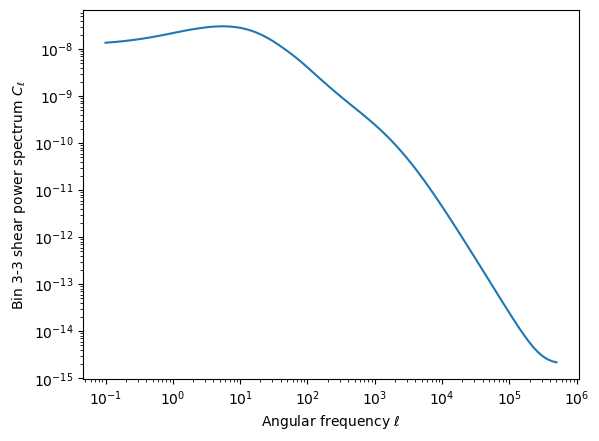

In [27]:
ell = results.block['shear_cl', 'ell']
cl33 = results.block['shear_cl', 'bin_3_3']
plt.loglog(ell, cl33)
plt.xlabel("Angular frequency $\ell$")
plt.ylabel("Bin 3-3 shear power spectrum $C_\ell$");

# Post-processing chains

Instead of manually making plots from chain output, as we did above, we can ask CosmoSIS to do it for us. The advantage of this is that it knows about the different types of chain - whether they have weights or not, for example, and how to make a plot of each one.

In [28]:
results = cosmosis.postprocessing.run_cosmosis_postprocess([chain1])

 - 1D plot  cosmological_parameters--omega_m
 - 1D plot  cosmological_parameters--h0
 - 1D plot  cosmological_parameters--omega_k
 - 1D plot  supernova_params--m
 - 1D plot  cosmological_parameters--ommh2
(Making 2D plots using KDE; this takes a while but is really cool)
  (making cosmological_parameters--omega_m vs cosmological_parameters--h0)
  (making cosmological_parameters--omega_m vs cosmological_parameters--omega_k)
  (making cosmological_parameters--omega_k vs cosmological_parameters--h0)
  (making supernova_params--m vs cosmological_parameters--omega_m)
  (making supernova_params--m vs cosmological_parameters--h0)
  (making supernova_params--m vs cosmological_parameters--omega_k)
  (making supernova_params--m vs cosmological_parameters--ommh2)
  (making cosmological_parameters--ommh2 vs cosmological_parameters--omega_m)
  (making cosmological_parameters--ommh2 vs cosmological_parameters--h0)
  (making cosmological_parameters--ommh2 vs cosmological_parameters--omega_k)
 - Trace

/Users/jzuntz/src/cosmosis/cosmosis/cosmosis/plotting/kde.py:29: RuntimeWarning: invalid value encountered in divide
  normalized_points.append((column-col_mean)/col_std)


Most of the information of interest will be in the `results.outputs` dictionary. Its values are output objects

In [29]:
for key in results.outputs.keys():
    print(key)

cosmological_parameters--omega_m
cosmological_parameters--h0
cosmological_parameters--omega_k
supernova_params--m
cosmological_parameters--ommh2
2D_cosmological_parameters--omega_m_cosmological_parameters--h0
2D_cosmological_parameters--omega_m_cosmological_parameters--omega_k
2D_cosmological_parameters--omega_k_cosmological_parameters--h0
2D_supernova_params--m_cosmological_parameters--omega_m
2D_supernova_params--m_cosmological_parameters--h0
2D_supernova_params--m_cosmological_parameters--omega_k
2D_supernova_params--m_cosmological_parameters--ommh2
2D_cosmological_parameters--ommh2_cosmological_parameters--omega_m
2D_cosmological_parameters--ommh2_cosmological_parameters--h0
2D_cosmological_parameters--ommh2_cosmological_parameters--omega_k
corner
trace_cosmological_parameters--omega_m
trace_cosmological_parameters--h0
trace_cosmological_parameters--omega_k
trace_supernova_params--m
trace_cosmological_parameters--ommh2
trace_prior
trace_post
means
medians
modes
l95
u95
l68
u68
lerr

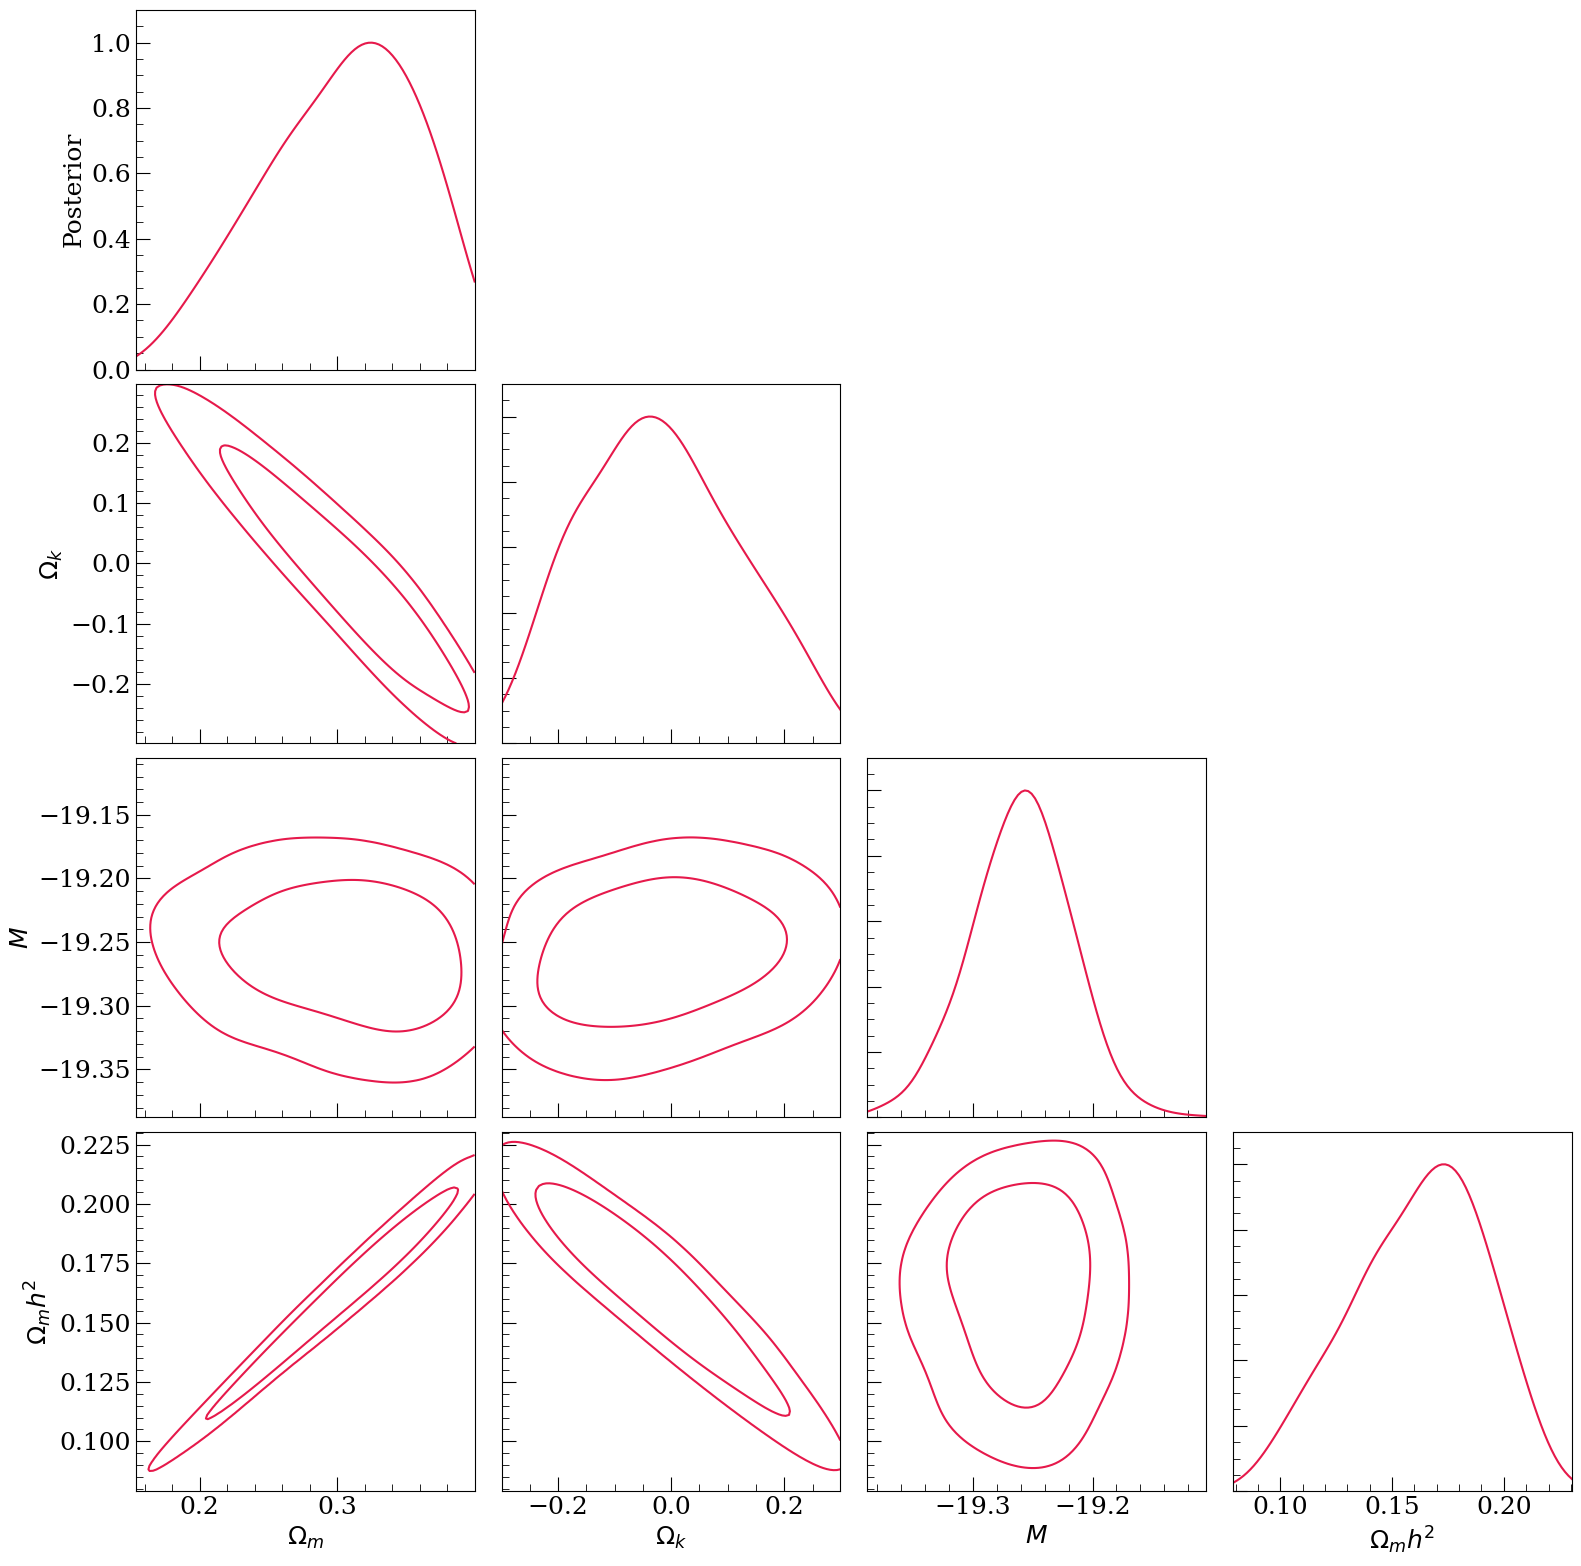

In [30]:
r=results.outputs['corner']
r.value

In [31]:
r=results.outputs['u95']
r.value.to_astropy()

parameter,u95,data_set
str32,float64,str7
cosmological_parameters--omega_m,0.38301120583904713,chain_0
cosmological_parameters--h0,0.7518455907318123,chain_0
cosmological_parameters--omega_k,0.2141087565451413,chain_0
supernova_params--m,-19.196005540245203,chain_0
cosmological_parameters--ommh2,0.20582640767777718,chain_0
prior,2.407945608651871,chain_0
post,-18.63596685583259,chain_0


In [32]:
chain_tmp = chain1[3000:]
results = cosmosis.postprocessing.run_cosmosis_postprocess([chain1, chain_tmp], legend="Emcee|Nautilus")

 - 1D plot  cosmological_parameters--omega_m
 - 1D plot  cosmological_parameters--h0
 - 1D plot  cosmological_parameters--omega_k
 - 1D plot  supernova_params--m
 - 1D plot  cosmological_parameters--ommh2
(Making 2D plots using KDE; this takes a while but is really cool)
  (making cosmological_parameters--omega_m vs cosmological_parameters--h0)
  (making cosmological_parameters--omega_m vs cosmological_parameters--omega_k)
  (making cosmological_parameters--omega_k vs cosmological_parameters--h0)
  (making supernova_params--m vs cosmological_parameters--omega_m)
  (making supernova_params--m vs cosmological_parameters--h0)
  (making supernova_params--m vs cosmological_parameters--omega_k)
  (making supernova_params--m vs cosmological_parameters--ommh2)
  (making cosmological_parameters--ommh2 vs cosmological_parameters--omega_m)
  (making cosmological_parameters--ommh2 vs cosmological_parameters--h0)
  (making cosmological_parameters--ommh2 vs cosmological_parameters--omega_k)
 - Trace

/Users/jzuntz/src/cosmosis/cosmosis/cosmosis/plotting/kde.py:29: RuntimeWarning: invalid value encountered in divide
  normalized_points.append((column-col_mean)/col_std)


  (making cosmological_parameters--omega_m vs cosmological_parameters--omega_k)
  (making cosmological_parameters--omega_k vs cosmological_parameters--h0)
  (making supernova_params--m vs cosmological_parameters--omega_m)
  (making supernova_params--m vs cosmological_parameters--h0)
  (making supernova_params--m vs cosmological_parameters--omega_k)
  (making supernova_params--m vs cosmological_parameters--ommh2)
  (making cosmological_parameters--ommh2 vs cosmological_parameters--omega_m)
  (making cosmological_parameters--ommh2 vs cosmological_parameters--h0)
  (making cosmological_parameters--ommh2 vs cosmological_parameters--omega_k)
 - Trace plot  cosmological_parameters--omega_m
 - Trace plot  cosmological_parameters--h0
 - Trace plot  cosmological_parameters--omega_k
 - Trace plot  supernova_params--m
 - Trace plot  cosmological_parameters--ommh2
 - Trace plot  prior
 - Trace plot  post
Samples after cutting: 3600

Marginalized mean, std-dev:
    cosmological_parameters--omega_m 

/Users/jzuntz/src/cosmosis/cosmosis/cosmosis/postprocessing/utils.py:42: RuntimeWarning: invalid value encountered in divide
  x = (v-mu)/sigma


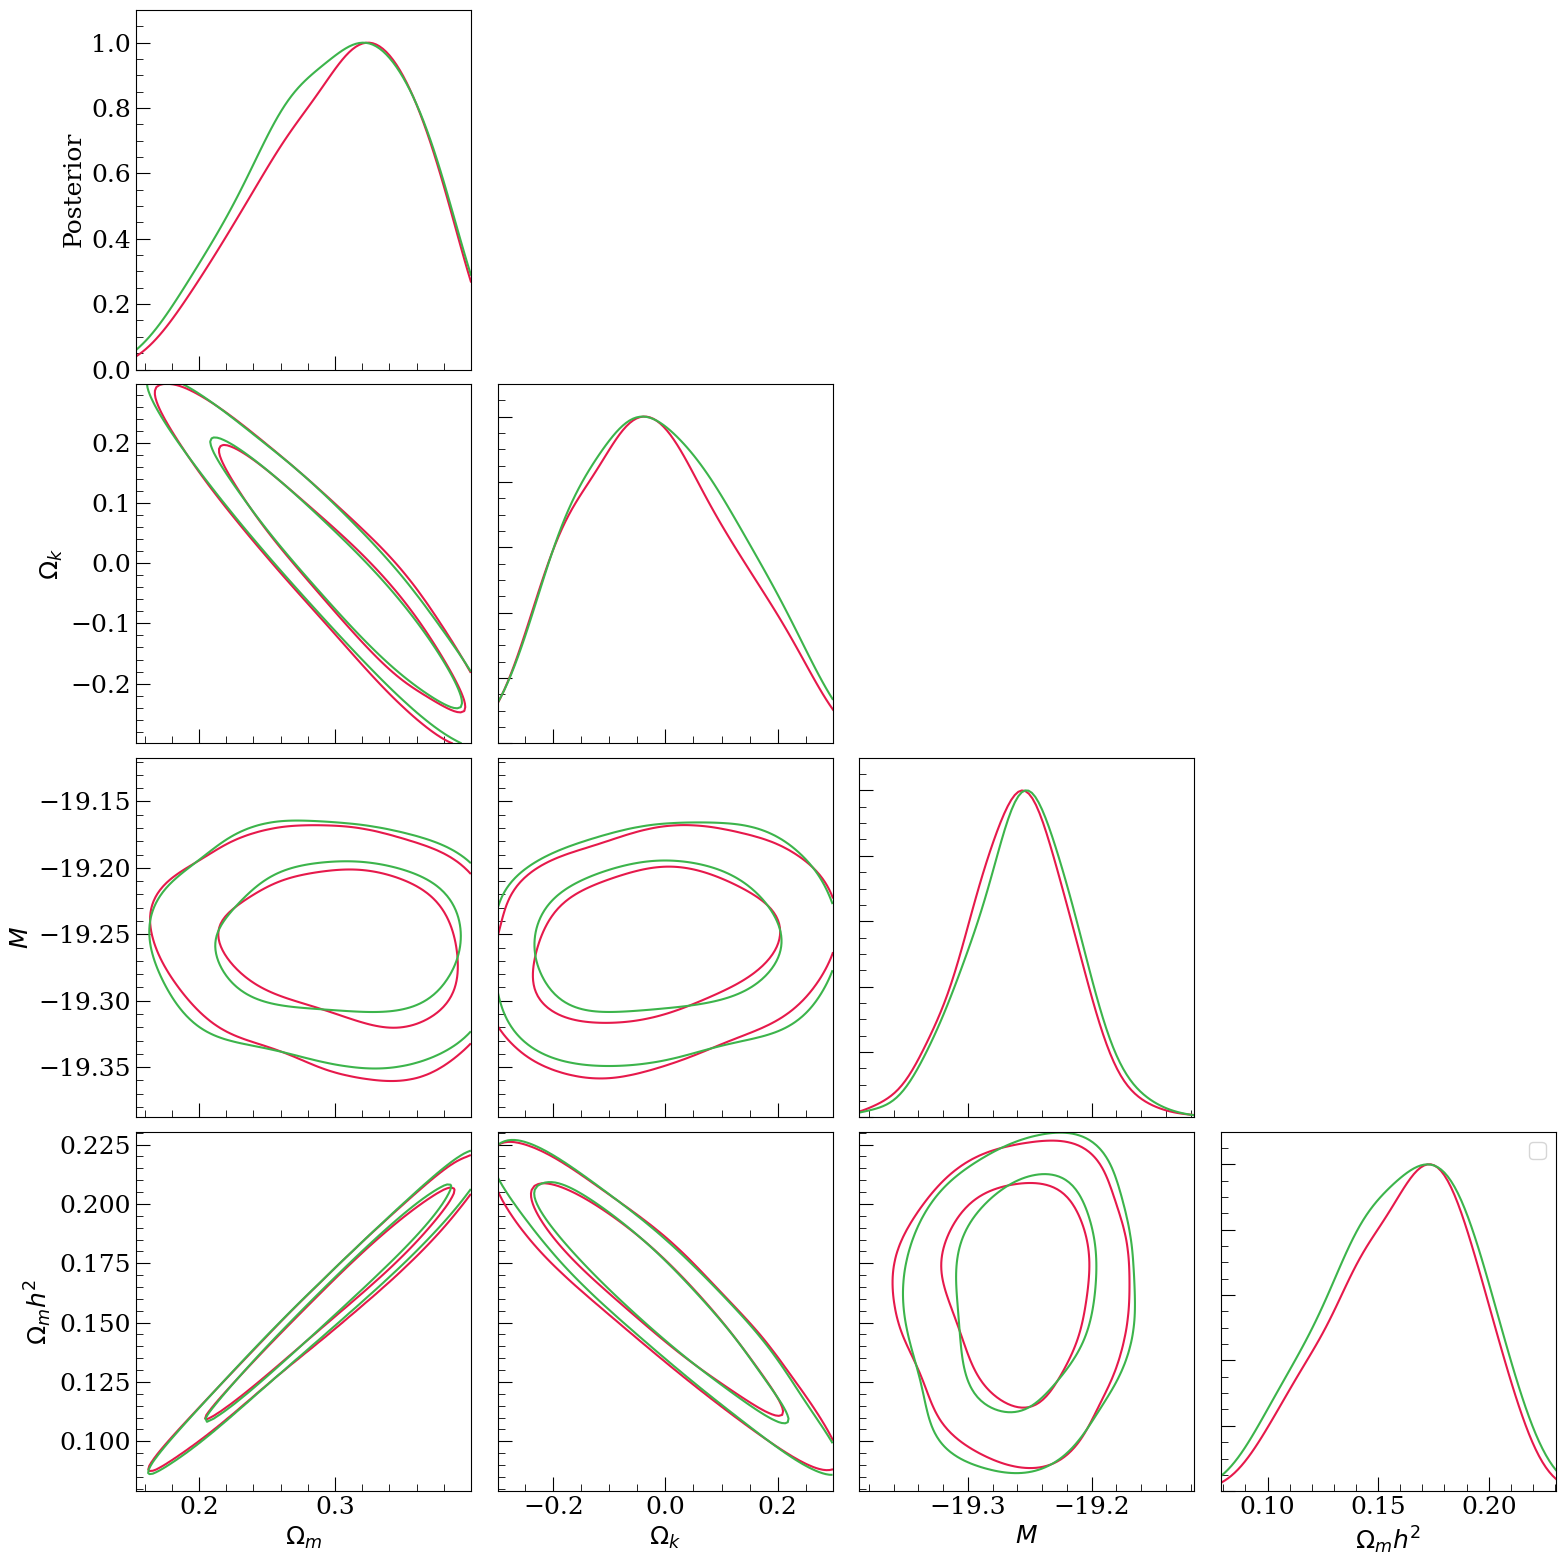

In [33]:
results.outputs['corner'].value

In [34]:
results.outputs['modes'].value.to_astropy()

parameter,modes,sigma,data_set
str32,float64,float64,str8
cosmological_parameters--omega_m,0.32239938308772786,0.05410661160232988,Emcee
cosmological_parameters--h0,0.7277912713984315,0.013153718017527035,Emcee
cosmological_parameters--omega_k,-0.06329060388911428,0.1332801929562442,Emcee
supernova_params--m,-19.255815296854227,0.040813306515946855,Emcee
cosmological_parameters--ommh2,0.17671060291825522,0.02903896496405144,Emcee
prior,nan,4.440892098500626e-16,Emcee
post,-19.254739785917497,1.2666418795087506,Emcee
cosmological_parameters--omega_m,0.3209188443754556,0.05505239073474754,Nautilus
cosmological_parameters--h0,0.7346084844844256,0.013092732514922002,Nautilus
